## Deprecated File, Only for Reference

## Automated Detection of Layers from Pictures

This cell loads one image at a time.

Symmetry functions of spglib enabled
SimpleITK not installed; Registration Functions for Image Stacks not available
install with: conda install -c simpleitk simpleitk 
Non-Stacked


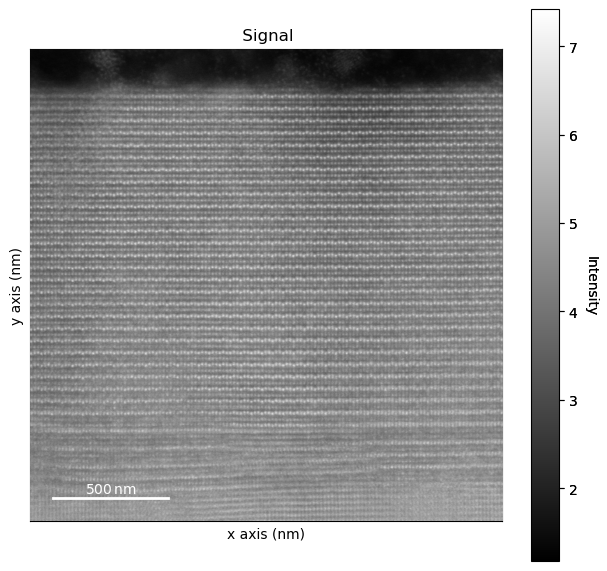

In [2]:
import skimage
import matplotlib.pyplot as plt
import hyperspy.api as hs
import sys
sys.path.append('..')
import util.layer as layer
import util.crop as crop

stack_num = 0 # The index of stacked image

# Change the name of s_load to load different plots.
# Note that some datasets are in stacks and their data will be 3-dimension,
# where the first dimention is the index of a single stacked image. We want to
# look at one image each of the time, so for those stacked images, please change
# stack_num to view different images.

# Load one file at a time.
# These commented files are some that I want think could be reevaluated later for references.
s_load = hs.load('../data/images/Jaume LFO/HAADF_01.dm3')

if len(s_load.data.shape) == 2: # Non-stacked
    print("Non-Stacked")
    s = s_load
else: # Stacked, where s_load.data.shape = 3
    print("Stacked")
    s = s_load.inav[stack_num]

# Plot the image in pixels. We can plot in nanometers by simply doing s.plot().
import copy
s_copy = copy.deepcopy(s)
for ax in s_copy.axes_manager.signal_axes:
    ax.scale = 1.0
    ax.offset = 0.0

plt.close()
s_copy.plot()

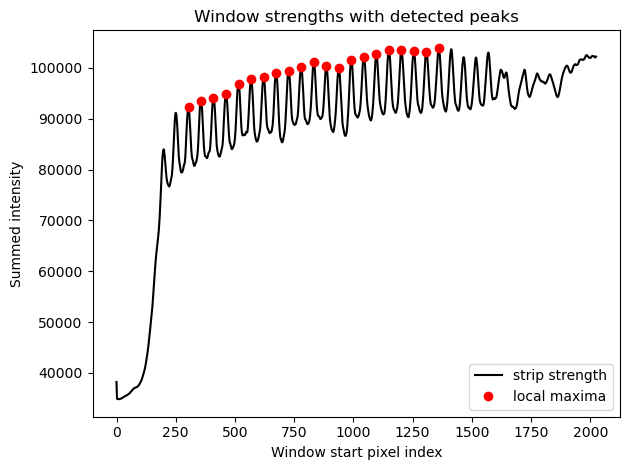

Indices of local peaks: [ 304  357  409  462  515  568  621  673  726  780  833  885  938  991
 1044 1097 1150 1202 1255 1308 1360]


In [3]:
import scipy.signal
import numpy as np

left_bound = 600 # TUNE THIS
right_bound = 1500 # TUNE THIS
start_pixel = 280 # TUNE THIS
end_pixel = 1400 # TUNE THIS
window_height_nm = 0.28 # TUNE THIS   

crop = crop.Crop(s, left_bound, right_bound, start_pixel, end_pixel, window_height_nm)
peak_indices = crop.get_windows(get_plot=True)
print("Indices of local peaks:", peak_indices)

To see whether the window heights, left and right boundaries we have chosen make sense, we test all of the windows by interating through the indices of windows and see the results in the cell below and adjust accordingly. If some windows are clearly not aligned (e.g. falling above or below the window), please feel free to crop them off from this test.

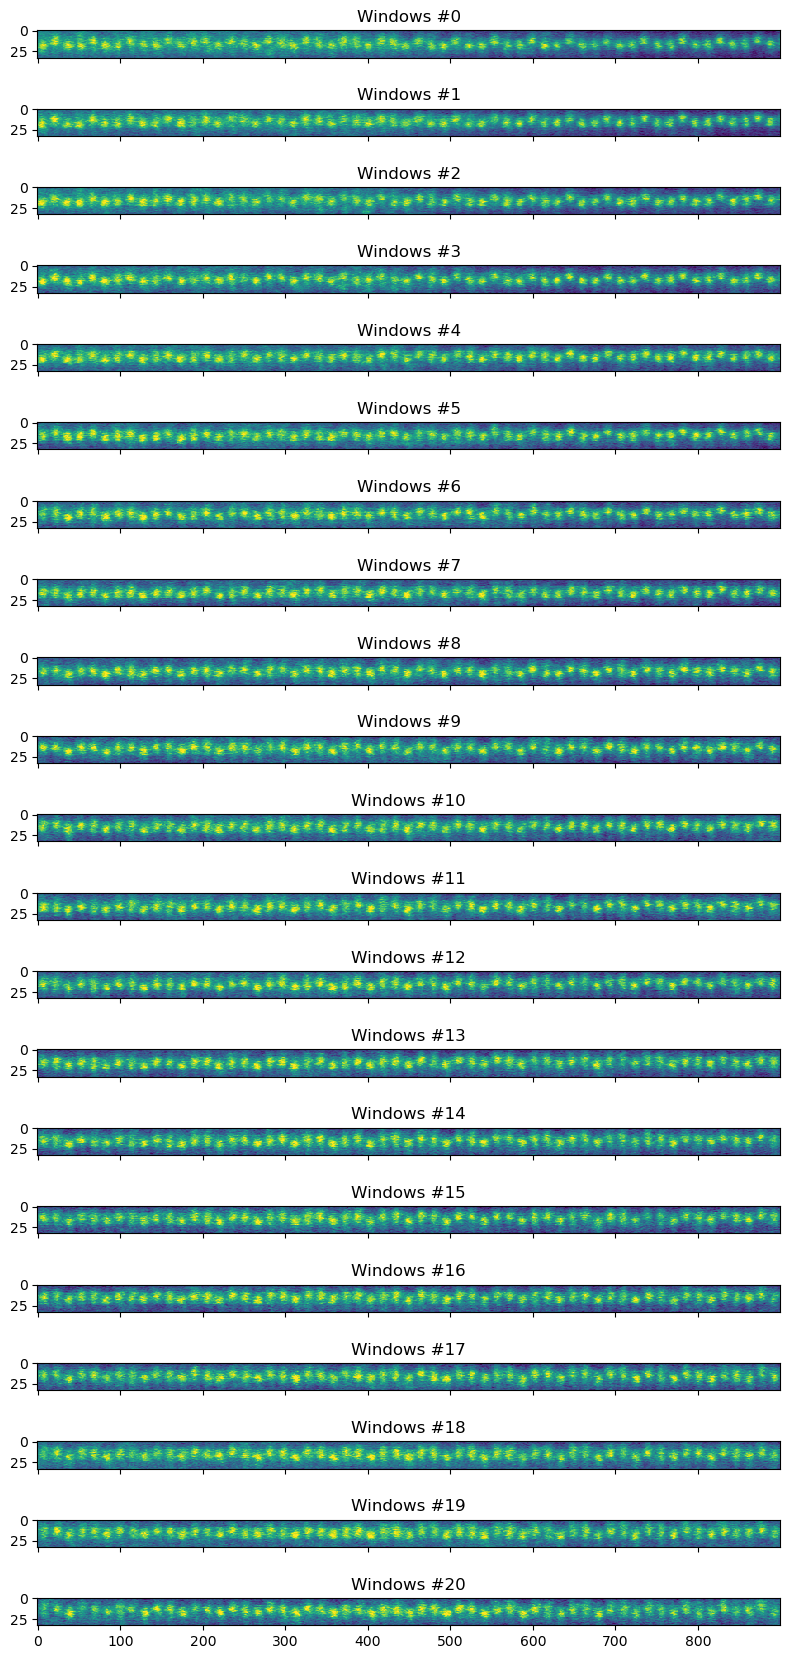

In [4]:
get_plot = True
if get_plot:
    windows_num = len(crop.layers)
    fig, ax = plt.subplots(windows_num, 1, figsize=(8, windows_num*0.8), sharex=True, sharey=True)
    for window_index in range(windows_num):
        layer = crop.layers[window_index]
        s_cropped = layer.image
        ax[window_index].imshow(s_cropped, interpolation='nearest', vmax=np.median(np.array(s_cropped))+3*np.std(np.array(s_cropped)))
        ax[window_index].set_title(f'Windows #{window_index}')

    plt.tight_layout()

## Atom Positions Finding & Refining Functions

We could check using the codes below to see how does atom detections do in one sliced window. We can change the index to view how it works for all these windows. Use "get_plot = True" and any function to get a plot of processing at that stage.

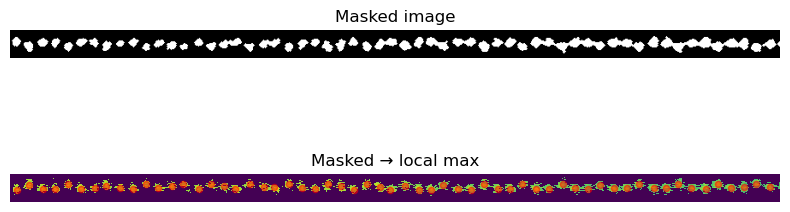

In [5]:
window_ind = 0
layer = crop.layers[window_ind]
layer.atom_finding(disk_param_nm = 0.235, obj_param_nm = 0.2, holes_param_nm = 0.2,
                    min_separation_nm = 0.095, get_plot_thresholding = False, 
                    get_plot_cleaning = False, get_plot_positions = True)

We run through all the detected windows of Lu atoms iteratively. The results will be stored in a dictionary refind_atoms_dict.

We also need to take care of are the distances between atoms. Are they too far or too close to the neighboring atoms? To handle these, we only need to look at the x-axis (because it is impossible that two atoms, with one of them are abnormal, are too far apart of too close together on the y-axis while being normal on the x-axis). Running our detection iteratively, we can store all the outliers in the windows and we can see where outliers are.

In [6]:
for window_ind in range(len(crop.layers)):
    crop.layers[window_ind].atom_finding(disk_param_nm = 0.235, obj_param_nm = 0.2, holes_param_nm = 0.2,
                        min_separation_nm = 0.095)
    crop.layers[window_ind].filling_blanks(sigma_allowance = 4)
    

After all, refine atom locations based on iterations towards fitting a Gaussian shape based on the atom radius.

In [7]:
%%capture
for window_ind in range(len(crop.layers)):
    # crop.layers[window_ind].atom_refine_hs(get_plot = False, atom_radius_nm = 0.174)
    crop.layers[window_ind].atom_refine_hs(get_plot = False)

AttributeError: 'Layer' object has no attribute 'atom_refine_hs'

We can see what one window is like by peaking at one of it:

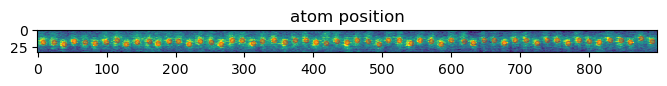

In [8]:
plot_ind = 11
crop.layers[plot_ind].plot_layer()

Keep in mind that the same set of input parameters can possibly only work for like a part of an image. So we do need to crop a smaller size to analyze.

## Atom Finding in Atomap

In [9]:
%matplotlib widget
import atomap.api as am
window_ind = 2
layer = crop.layers[window_ind]
s_peaks = am.get_feature_separation(layer.image, separation_range=(2, 20), show_progressbar=False)
s_peaks.plot()

Text(0.5, 1.0, 'atom position')

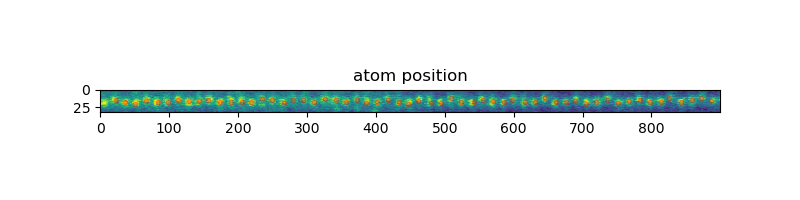

In [10]:
window_ind = 2
layer = crop.layers[window_ind]
atom_positions = am.get_atom_positions(layer.image, separation=9)
sublattice = am.Sublattice(atom_positions, image=layer.image)
# sublattice.find_nearest_neighbors()
# sublattice.refine_atom_positions_using_center_of_mass()
# sublattice.refine_atom_positions_using_2d_gaussian()

plt.figure(figsize=(8,2))
plt.imshow(layer.image, interpolation='nearest', vmax=np.median(np.array(layer.image))+3*np.std(np.array(layer.image)))
plt.scatter(sublattice.atom_positions[:,0], sublattice.atom_positions[:,1], s=10, alpha = 0.3, color = 'red')
plt.title('atom position')

In [11]:
atom_positions

array([[173,  18],
       [ 36,  18],
       [129,  16],
       [219,  18],
       [ 84,  18],
       [356,  18],
       [113,  14],
       [814,  17],
       [ 50,  20],
       [705,  20],
       [205,  17],
       [542,  18],
       [156,  14],
       [843,  18],
       [249,  15],
       [783,  14],
       [887,  16],
       [494,  19],
       [735,  14],
       [143,  16],
       [598,  14],
       [ 66,  16],
       [189,  18],
       [267,  19],
       [447,  20],
       [767,  16],
       [ 23,  14],
       [570,  16],
       [433,  18],
       [798,  17],
       [461,  16],
       [386,  19],
       [662,  18],
       [523,  17],
       [509,  12],
       [586,  18],
       [417,  15],
       [631,  18],
       [310,  17],
       [645,  12],
       [872,  11],
       [752,  19],
       [ 98,  17],
       [342,  14],
       [720,  18],
       [616,  17],
       [402,  17],
       [689,  16],
       [326,  13],
       [859,  14],
       [294,  15],
       [235,  13],
       [556,